In [ ]:
# default_exp tfit_domain

In [ ]:
# export
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

In [ ]:
import pickle
import sys
from math import ceil

import keras.applications.xception as xce
import matplotlib
import numpy
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans

from grade_classif.data.read import get_items
from grade_classif.imports import *
from grade_classif.models.plmodules import Normalizer

import shutil
from itertools import combinations

import matplotlib.pyplot as plt
from fastai.data.transforms import get_files
from keras import backend as K
from keras.callbacks import Callback
from keras.constraints import unit_norm
from keras.layers import Dropout, Lambda
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
from slideminer.data.datagen import SingleClassBatchGeneratorFromFolder
from slideminer.description import networks
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from argparse import Namespace
from torchvision.transforms.functional import to_tensor
from albumentations import (
    RandomCrop,
    RandomRotate90,
    Flip,
    Transpose,
    RandomGamma,
    GaussianBlur,
    Compose,
)

In [ ]:
#### #
# FUNCTIONS AND CLASSES
#
########################################################################


def create_monitor(datafolder, batch_size, steps, info_dir, every_n=100):
    """
    Create a tf.keras callback class to monitor cosine similarity.

    ***********************************************************
    """

    class Monitor(Callback):
        def on_train_begin(self, logs={}):
            self.info_dir = info_dir
            self.datafolder = datafolder
            self.steps = steps
            self.batch_size = batch_size
            self.inter_cosine_dist = []
            self.intra_cosine_dist = []
            self.every_n = every_n
            self.classfolders = {}
            self.imlists = {}
            for name in os.listdir(self.datafolder):
                classdir = os.path.join(self.datafolder, name)
                if os.path.isdir(classdir):
                    self.classfolders[name] = classdir
                    imlist = []
                    for imname in os.listdir(classdir):
                        if imname.endswith(".png"):
                            filename = os.path.join(classdir, imname)
                            imlist.append(filename)
                    self.imlists[name] = imlist

        def on_batch_end(self, batch, logs={}):
            if batch % self.every_n == 0:
                # create a new model from the global one
                eval_model = tf.keras.Model(
                    inputs=self.model.input,
                    outputs=self.model.get_layer("features").output,
                )
                cosine_inter = {}
                cosine_intra = {}
                centroids = {}
                for classname, classfolder in self.classfolders.items():
                    gen = SingleClassBatchGeneratorFromFolder(
                        self.imlists[classname], self.batch_size
                    )
                    print("Evaluation of class: {}".format(classname))
                    preds = eval_model.predict(gen, steps=self.steps)
                    n = numpy.linalg.norm(preds, axis=1)
                    preds /= n[:, numpy.newaxis]
                    # compute cosine intra
                    centroids[classname] = numpy.mean(preds, axis=0)
                    meanpreds = numpy.stack(
                        [centroids[classname] for k in range(len(preds))]
                    )
                    # cosine dist to centroid
                    dotprod = (preds * meanpreds).sum(axis=1)
                    cosine_intra[classname] = (1.0 - dotprod).mean(axis=0)

                for classid1, classid2 in combinations(self.classfolders.keys(), 2):
                    if classid1 < classid2:
                        k = "{}-{}".format(classid1, classid2)
                    else:
                        k = "{}-{}".format(classid2, classid1)
                    # print("Evaluation of tuple {}".format(k))
                    # compute cosine dist
                    # dot prod of 2 unit vectors
                    # perfect similarity is 1.
                    dotprod = (centroids[classid1] * centroids[classid2]).sum()
                    # I want distance, not similarity, so 1 - dotprod
                    cosine_inter[k] = 1.0 - dotprod
                self.inter_cosine_dist.append(cosine_inter)
                self.intra_cosine_dist.append(cosine_intra)

        def on_train_end(self, logs={}):
            with open(os.path.join(self.info_dir, "inter_cosine.p"), "wb") as f:
                pickle.dump(self.inter_cosine_dist, f)
            with open(os.path.join(self.info_dir, "intra_cosine.p"), "wb") as f:
                pickle.dump(self.intra_cosine_dist, f)

    return Monitor

In [ ]:
class MyDataset(Dataset):
    def __init__(self, files, labels=None, epochs=None, tfms=None):
        super().__init__()
        if labels is not None:
            assert len(files) == len(labels), (
                "There must be as many labels as files. "
                f"Currently {len(files)} files and {len(labels)} labels."
            )
        self.files = files
        self.labels = labels
        self.epochs = 1 if epochs is None else epochs
        self.tfms = tfms

    def __len__(self):
        return len(self.files) * self.epochs

    def __getitem__(self, idx):
        idx = idx % len(self.files)
        f = self.files[idx]
        img = imread(str(f))
        if self.tfms is not None:
            augmented = self.tfms(image=img)
            img = augmented["image"]
        img = to_tensor(img)
        if self.labels is None:
            return img
        else:
            return img, self.labels[idx]

In [ ]:
def _normalize(norm, x):
    x = x.to(norm.main_device)
    x = norm.predict(x).detach().clamp(0, 1).cpu().numpy()
    return (x.transpose(0, 2, 3, 1) * 255).astype(np.uint8)

In [ ]:
def load_data(files, datalim, norm=None, probas=None, batchsize=64):
    """
    Load image data.

    Given a folder and a max file number.
    """
    # first, get all filenames

    # shuffle the dataset
    data = []
    print("-" * 20)
    print("Loading data:")
    print("-" * 20)
    ds = MyDataset(files)
    sampler = WeightedRandomSampler(probas, datalim, replacement=False)
    dl = DataLoader(
        ds, batch_size=batchsize, num_workers=4, pin_memory=True, sampler=sampler
    )
    for x in tqdm(dl, total=len(dl)):
        x = _normalize(norm, x)
        data.append(x)
    torch.cuda.empty_cache()
    return xce.preprocess_input(numpy.concatenate(data))

In [ ]:
def yield_data(files, norm=None, batchsize=64):
    """
    Load image data.

    Given a folder and a max file number.
    """
    # first, get all filenames

    # shuffle the dataset
    ds = MyDataset(files)
    dl = DataLoader(
        ds,
        batch_size=batchsize,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
        timeout=60,
    )
    for x in tqdm(dl, total=len(dl)):
        x = _normalize(norm, x)
        yield xce.preprocess_input(x)
    torch.cuda.empty_cache()

In [ ]:
def fit_data_generator(files, labels, norm=None, batchsize=64, epochs=20, tfms=None):
    ds = MyDataset(files, labels=labels, epochs=epochs, tfms=tfms)
    dl = DataLoader(
        ds,
        shuffle=True,
        batch_size=batchsize,
        num_workers=4,
        pin_memory=True,
        timeout=60,
    )
    for x, y in dl:
        x = _normalize(norm, x)
        yield xce.preprocess_input(x), y.numpy()
    torch.cuda.empty_cache()

In [ ]:
def load_model(outdirectory, iteration):
    """
    Re-load a previously fine-tuned model.

    Given an iteration number (iteration to re-load).
    """
    # load json and create model
    with open(os.path.join(outdirectory, "model/xception.json"), "r") as json_file:
        loaded_model_json = json_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(
        os.path.join(outdirectory, "weights/iter_{}.h5".format(iteration))
    )
    print("Loaded model from disk")
    # compilation is useless if model is loaded for prediction only
    # loaded_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=loss)
    return loaded_model


def save_model(model, weightdirectory, iteration):
    """
    Save the weights of the model in a h5 file.

    Given a model and its iteration number, save the model.
    """
    model.save_weights(os.path.join(weightdirectory, "iter_{}.h5".format(iteration)))

In [ ]:
def color_cycle(size):
    """
    Define a color circle for the tsne plot of the classes.

    *******************************************************
    """
    cycle = ["r", "g", "b", "c", "m", "y", "k", "gray", "orange", "purple"]
    colors = []
    for k in range(size):
        colors.append(cycle[k % len(cycle)])
    return colors

In [ ]:
def flow_from_generator(datagen, generator):
    for batch_x, batch_y in generator:
        for i in range(batch_x.shape[0]):
            x = batch_x[i]
            params = datagen.get_random_transform(x.shape)
            x = datagen.apply_transform(x, params)
            x = datagen.standardize(x)
            batch_x[i] = x
        yield batch_x, batch_y


ImageDataGenerator.flow_from_generator = flow_from_generator

In [ ]:
def domain_adaption(
    datafolder,
    outdir,
    device,
    imsize,
    norm,
    epochs=20,
    iterations=5,
    n_clusters=10,
    threshold=0.75,
    datalim=25000,
    batchsize=16,
    metric_learning=True,
):
    """
    Adapt a neural network to a new kind of images.

    Usually a network previously trained on imagenet.
    See tf.keras applications.
    """
    # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    # os.environ["CUDA_VISIBLE_DEVICES"] = device

    model_dir = os.path.join(outdir, "model")
    weights_dir = os.path.join(outdir, "weights")
    info_dir = os.path.join(outdir, "info")

    tfms = Compose(
        [
            RandomCrop(imsize, imsize),
            RandomRotate90(),
            Flip(),
            Transpose(),
            RandomGamma(p=0.2),
            GaussianBlur(blur_limit=3, p=0.2),
        ]
    )

    # create directories
    ###############################
    """if os.path.exists(outdir):
        # Be careful, this erase all previous work in this directory
        shutil.rmtree(outdir)"""
    os.makedirs(outdir)
    os.makedirs(model_dir)
    os.makedirs(weights_dir)
    os.makedirs(info_dir)
    ##################################################

    # GPU for similarity matrix computation
    ###################################################
    def similarity(center_t, other_t):
        center_t_norm = tf.nn.l2_normalize(center_t, axis=1)
        other_t_norm = tf.nn.l2_normalize(other_t, axis=1)
        return tf.matmul(
            center_t_norm, other_t_norm, transpose_a=False, transpose_b=True
        )

    ###########################################################

    # Gather images in a numpy array
    ########################################################
    classes = ["04", "05", "08"]

    def _label_func(x):
        for c in classes:
            if f"PACS{c}" in x.name:
                return c

    files = get_files(datafolder, extensions=[".png"])
    pacs_labels = files.map(_label_func)
    pacs_labels = np.array(pacs_labels)
    class_probas = np.array([1 / (pacs_labels == c).sum() for c in classes])
    probas = np.zeros(len(pacs_labels))
    for c in classes:
        probas[pacs_labels == c] = class_probas[classes.index(c)]
    probas /= probas.sum()
    ########################################################

    # Before we start, we instantiate and store xception pre-trained model
    ############################################
    base_model = xce.Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(imsize, imsize, 3),
        pooling="avg",
    )
    json_string = base_model.to_json()
    with open(os.path.join(model_dir, "xception.json"), "w") as text_file:
        text_file.write(json_string)
    save_model(base_model, weights_dir, 0)
    ##############

    # create a tensorflow session before we start

    # Main Loop
    ###################################
    for checkpoint in range(1, iterations + 1):
        K.clear_session()

        # extract features
        print("-" * 20)
        print("predicting features:")
        print("-" * 20)
        sample_idxs = np.random.choice(np.arange(len(files)), datalim, False, probas)
        epoch_files = files[sample_idxs]
        features = base_model.predict(
            yield_data(epoch_files, norm=norm, batchsize=batchsize)
        )
        features = np.array(features)

        K.clear_session()
        del base_model

        # instance of k-means
        print("-" * 20)
        print("fitting k-means:")
        print("-" * 20)
        kmeans = KMeans(n_clusters=n_clusters)
        distances = kmeans.fit_transform(features)

        # select best candidates for k-means centers in the dataset
        center_idx = np.argmin(distances, axis=0)
        centers = np.array([features[i] for i in center_idx])

        # compute similarity matrix
        print("-" * 20)
        print("similarity matrix:")
        similarities = similarity(centers, features).numpy()
        print("similarity has shape: ", similarities.shape)
        print("similarity: ", similarities)
        print("-" * 20)

        # select images closest to centers
        print("-" * 20)
        print("reliability selection:")
        print("-" * 20)
        reliable_image_idx = np.unique(np.argwhere(similarities > threshold)[:, 1])
        print(
            "checkpoint {}: # reliable images {}".format(
                checkpoint, len(reliable_image_idx)
            )
        )
        sys.stdout.flush()
        int_labels = np.array([kmeans.labels_[i] for i in reliable_image_idx])
        labels = to_categorical(int_labels)

        # write a tsne visualization figure, to check if visualization improves
        print("-" * 20)
        print("TSNE figure:")
        tsne = TSNE(n_components=2)
        x2d = tsne.fit_transform(np.array([features[i] for i in reliable_image_idx]))
        print("TSNE shape: ", x2d.shape)
        print("TSNE: ", x2d)
        print("-" * 20)
        plt.figure(figsize=(6, 5))
        colors = color_cycle(n_clusters)
        for i, c, label in zip(
            list(range(n_clusters)), colors, [str(id) for id in range(n_clusters)]
        ):
            print("current_label: ", i)
            print("shape of kmeans predictions: ", int_labels.shape)
            print("kmeans predictions: ", int_labels)
            print("points in masked predictions: ", (int_labels == i).sum())
            plt.scatter(
                x2d[int_labels == i, 0], x2d[int_labels == i, 1], c=c, label=label
            )
        plt.legend()
        plt.title(
            "TSNE visualization, based on {} reliable images".format(
                len(reliable_image_idx)
            )
        )
        plt.savefig(os.path.join(info_dir, "tsne_iter_{}.png".format(checkpoint - 1)))

        # Fine tune
        print("-" * 20)
        print("Fine tuning:")
        print("-" * 20)
        base_model = xce.Xception(
            include_top=False,
            weights="imagenet",
            input_shape=(imsize, imsize, 3),
            pooling="avg",
        )

        # compute head of the classifier, for cosine learning
        renamer = Lambda(lambda t: t, name="features")
        regularizer = Dropout(0.8)
        if metric_learning:
            normalizer = Lambda(lambda t: K.l2_normalize(1000 * t, axis=-1))
            classifier = networks.CosineDense(
                n_clusters,
                use_bias=False,
                kernel_constraint=unit_norm(),
                activation="softmax",
            )
            y = renamer(base_model.output)
            y = normalizer(y)
            y = regularizer(y)
            y = classifier(y)
        else:
            classifier = tf.keras.layers.Dense(n_clusters, activation="softmax")
            y = renamer(base_model.output)
            y = regularizer(y)
            y = classifier(y)

        model = tf.keras.Model(inputs=base_model.input, outputs=y)
        callback = tf.keras.callbacks.EarlyStopping(
            monitor="loss", min_delta=0.005, patience=4
        )
        sched = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="loss", patience=1, factor=0.2, min_delta=0.02, min_lr=1e-5
        )
        model.compile(optimizer=Adam(lr=0.01), loss="categorical_crossentropy")
        gen = fit_data_generator(
            epoch_files[reliable_image_idx],
            labels,
            norm=norm,
            batchsize=batchsize,
            epochs=epochs,
            tfms=tfms,
        )
        model.fit(
            gen,
            steps_per_epoch=ceil(len(reliable_image_idx) / batchsize),
            epochs=epochs,
            callbacks=[sched, callback],
        )
        save_model(base_model, weights_dir, checkpoint)

In [ ]:
args = Namespace(
    datafolder="/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1",
    outfolder="/data/DeepLearning/SCHWOB_Robin/xception_weights_2",
    batch_size=8,
    size=299,
    open_mode="H",
    normalizer="cbr_5_32_4",
    resume="6cacb7558df8464a843775ca6694ed3b",
    epochs=30,
    iterations=20,
    gpus=[1],
    savedir="/data/DeepLearning/SCHWOB_Robin/models/logs",
    level=1,
    rand_weights=False,
    datalim=25000,
)

In [ ]:
norm = Normalizer(**vars(args))
norm.freeze()

gpu = args.gpus[0]

In [ ]:
with tf.device(f"/GPU:{gpu}"):
    domain_adaption(
        args.datafolder,
        args.outfolder,
        gpu,
        args.size,
        norm,
        epochs=args.epochs,
        iterations=args.iterations,
        batchsize=args.batch_size,
        datalim=args.datalim,
    )

In [ ]:
datafolder = args.datafolder

In [ ]:
files = get_files(datafolder, extensions=[".png"]); files

(#3005507) [Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_68172_68172.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_42458_68770.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_68172_68770.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_73554_68770.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_43056_69368.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Patches_normalized_299_1/1/CF_PACS04rescan_08P0124/CF_PACS04rescan_08P0124_31096_69966.png'),Path('/data/DeepLearning/SCHWOB_Robin/Patches_normalized_299/Pat

In [ ]:
classes = ["04", "05", "08"]


def _label_func(x):
    for c in classes:
        if f"PACS{c}" in x.name:
            return c


files = get_files(datafolder, extensions=[".png"])
labels = files.map(_label_func)
labels = numpy.array(labels)
class_probas = numpy.array([1 / (labels == c).sum() for c in classes])
probas = np.zeros(len(labels))
for c in classes:
    probas[labels == c] = class_probas[classes.index(c)]
probas /= probas.sum()

In [ ]:
n = len(files)

In [ ]:
for file in tqdm(files[int((0.175+0.06*0.825)*n):]):
    try:
        imread(str(file))
    except:
        print(file)

  0%|          | 24013/9451611 [00:57<5:59:07, 437.53it/s]

In [ ]:
sample_idxs = np.random.choice(np.arange(len(files)), args.datalim, False, probas)
epoch_files = files[sample_idxs]

In [ ]:
for c in classes:
    print(c, len(files.filter(lambda x: f'PACS{c}' in x.name)))

04 5856439
05 2375948
08 3955378


In [ ]:
tfms = Compose(
    [
        RandomCrop(args.size, args.size),
        RandomRotate90(),
        Flip(),
        Transpose()
    ]
)

In [ ]:
ds = MyDataset(epoch_files, tfms=tfms)
dl = DataLoader(
    ds,
    shuffle=False,
    batch_size=4,
    num_workers=4,
    pin_memory=True,
    timeout=60,
)

In [ ]:
dl = iter(dl)

In [ ]:
x = next(dl)

In [ ]:
x = _normalize(norm, x)

In [ ]:
%matplotlib inline

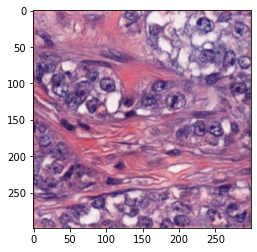

In [ ]:
plt.figure()
plt.imshow(x[0])

In [ ]:
x = xce.preprocess_input(x)

In [ ]:
with tf.device('/GPU:1'):
    base_model = xce.Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(args.size, args.size, 3),
        pooling="avg",
    )

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory